# Домашнее задание
* Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
* Реализовать самостоятельно логистическую регрессию
    * Обучить ее методом градиентного спуска
    * Методом nesterov momentum
    * Методом rmsprop
* В качестве dataset'а взять Iris, оставив 2 класса:
    * Iris Versicolor
    * Iris Virginica

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
iris_ds = load_iris()
X = pd.DataFrame(iris_ds['data'],columns=iris_ds['feature_names'])
y = pd.Series(iris_ds['target'],name='iris_type')
X = X[y.isin([1, 2])] #1=='versicolor', 2=='virginica'
y = y[y.isin([1, 2])] #1=='versicolor', 2=='virginica'
y = np.floor(y/2)
y = y.astype(int)
full_iris = pd.concat([X,y],axis=1)
assert len(X)==len(y)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42,shuffle=True)

#convert X to np.array for conviniece, add bias to support matrix multiplication
X_train = np.hstack([np.array(X_train),np.ones([len(X_train),1])])
X_test = np.hstack([np.array(X_test),np.ones([len(X_test),1])])

Here I assume that no major EDA is required, as DataSet is well known. So just sclaing and sanity checks.

In [3]:
full_iris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 5 columns):
sepal length (cm)    100 non-null float64
sepal width (cm)     100 non-null float64
petal length (cm)    100 non-null float64
petal width (cm)     100 non-null float64
iris_type            100 non-null int64
dtypes: float64(4), int64(1)
memory usage: 4.7 KB


/home/andrei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/andrei/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/andrei/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/andrei/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

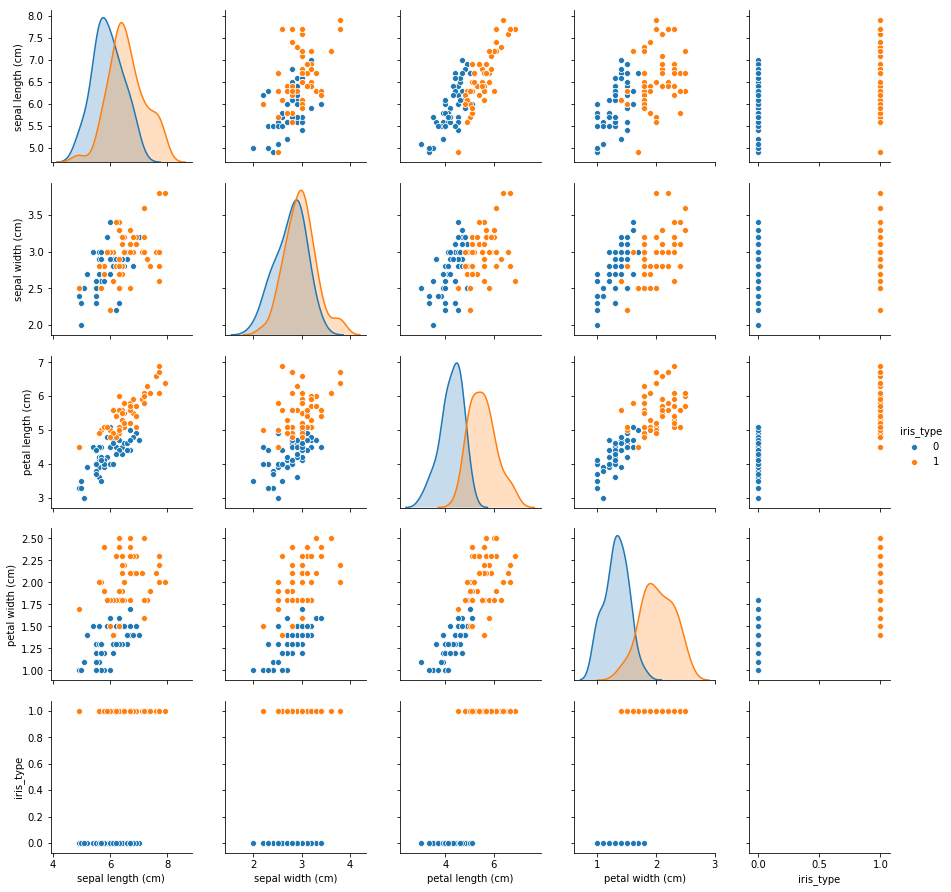

In [4]:
import seaborn as sbs
_ = sbs.pairplot(hue='iris_type',data=full_iris)

Classes looks very well separable from each other

# Logistic regression
https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc

In [5]:
def sigmoid(func):
    return 1/(1+np.exp(-func))
def log_reg_predict (X, params):
    if X.shape[1] != params.shape[0]:
        print ("Check your parameters - sahpe mismatch")
    else:        
        return sigmoid(np.dot(X,params))

In [6]:
test_params = np.array([0,0,0,0,0])
test_run_results = log_reg_predict(X_train,test_params)
assert test_run_results.reshape((-1,)).shape[0] == X_train.shape[0] #ensure that flattened array is correct
assert np.sum(test_run_results==.5) == X_train.shape[0] #with 0 coefficient all results should be .5

In [7]:
def log_reg_grad(X,params,y):
    return np.dot(sigmoid(np.dot(X,params) - y),X)/y.shape[0]

In [8]:
log_reg_grad(X_train,test_params,y_train)

array([2.34438203, 1.09594068, 1.80092925, 0.60723703, 0.37869425])

In [9]:
def log_reg_cost(X,params,y):
    pred = log_reg_predict(X,params)
    return -np.sum(y*np.log(pred)+(1-y)*np.log(1-pred))/len(y)

In [10]:
log_reg_cost(X_train,test_params,y_train)

0.6931471805599453

# Global performance metrics

In [11]:
performance = {}

# Gradient descent

Achieved minimum of cost function with LR=0.001 is 0.6478144510497057 at 144 epoch
Achieved minimum of cost function with LR=0.0001 is 0.6477917166306157 at 1440 epoch
Achieved minimum of cost function with LR=1e-05 is 3.6104528383861236 at 2000 epoch
Achieved minimum of cost function with LR=1e-06 is 4.209344827099981 at 2000 epoch
Achieved minimum of cost function with LR=1e-07 is 4.269256385474316 at 2000 epoch


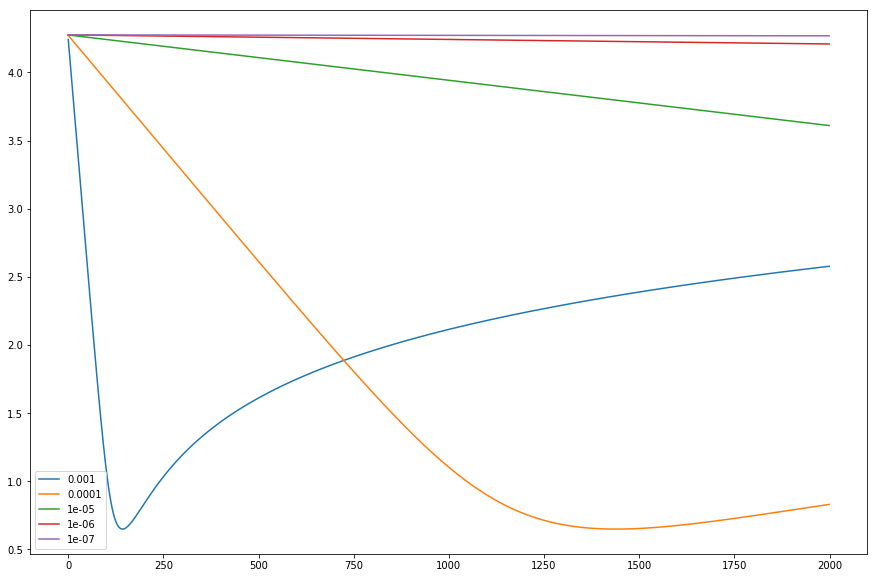

In [12]:
np.random.seed(42)
EPOCHS = 2000

init_params = np.random.uniform(size=X_train.shape[1])
minimum_costs = {}

global_gradients = []
global_params = []
global_costs = []

plt.figure(figsize=(15,10))
for LR in [.001,.0001,.00001,.000001,.0000001]:
    params = np.copy(init_params)
    
    costs = []
    grads_draw = []
    params_draw = [np.copy(params),]
    for _ in range(EPOCHS):
        gradients = log_reg_grad(X_train,params,y_train)
        grads_draw.append(gradients)
        params -= LR*gradients        
        params_draw.append(np.copy(params))
        #print(params)
        costs.append(log_reg_cost(X_train,params,y_train))
        
    print(f"Achieved minimum of cost function with LR={LR} is {np.min(costs)} at {np.argmin(costs)+1} epoch")  
    minimum_costs[LR] = np.min(costs)
    plt.plot(range(len(costs)),costs,label=LR)
    
    #print('Params change:')
    #print(params_draw[0])
    #print(params_draw[-1])
    
    global_gradients.append(grads_draw)
    global_params.append(params_draw)
    global_costs.append(costs)
    
plt.legend()
_ = plt.show()

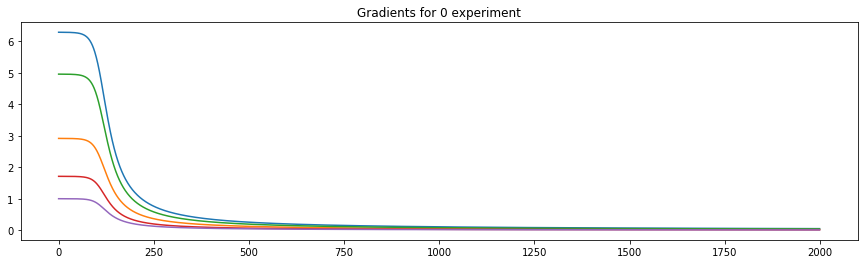

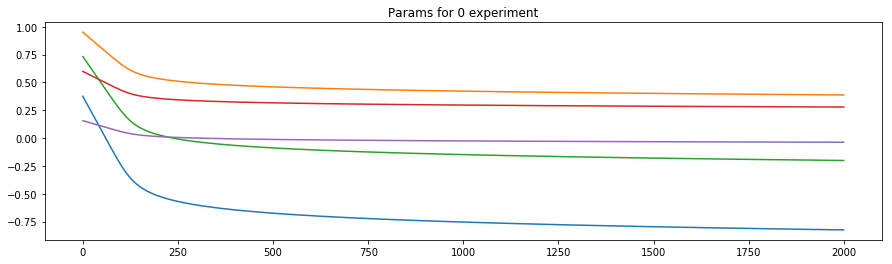

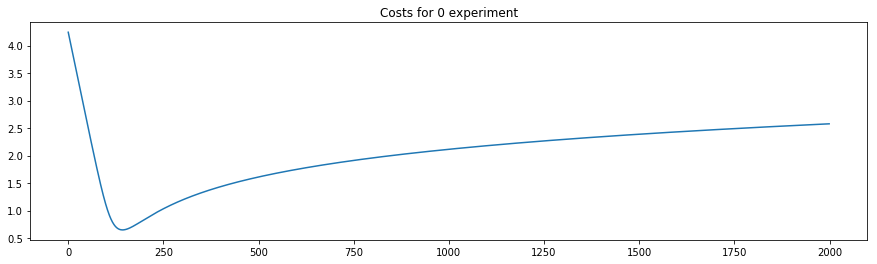

In [13]:
#debug
exp = 0

plt.figure(figsize=(15,4))
plt.title(f"Gradients for {exp} experiment")
plt.plot(global_gradients[exp])    
_ = plt.show()

plt.figure(figsize=(15,4))
plt.title(f"Params for {exp} experiment")
plt.plot(global_params[exp])    
_ = plt.show()

plt.figure(figsize=(15,4))
plt.title(f"Costs for {exp} experiment")
plt.plot(global_costs[exp])    
_ = plt.show()

We can see that gradient are vanishing with appropriate LR coefficient.

In [14]:
min_key = sorted(minimum_costs,key=lambda x:minimum_costs[x], reverse=False)[0]
print(min_key,minimum_costs[min_key])

0.0001 0.6477917166306157


From plot above we can see that with high LRs cost function diverges quickly. With low - converge too slow.
Two startegies:
1. Train longer with small LR
2. Impliment EarlyStopping

Achieved minimum of cost function with LR=1e-05 is 0.6477911619706395 at 14406 epoch


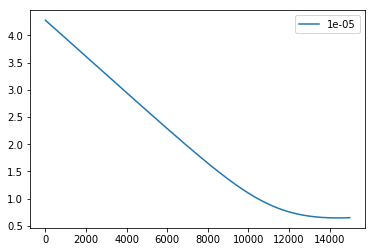

In [15]:
EPOCHS = 15000
LR = 1e-05

params = np.copy(init_params)
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,params,y_train)
    params -= LR*gradients
    #print(params)
    costs.append(log_reg_cost(X_train,params,y_train))

print(f"Achieved minimum of cost function with LR={LR} is {np.min(costs)} at {np.argmin(costs)+1} epoch")    
plt.plot(range(len(costs)),costs,label=LR)

plt.legend()
_ = plt.show()

If we train for long time with very small LR - similar result are achievable

EarlyStopping at 1441 epoch
Achieved minimum of cost function with LR=0.0001 is 0.6477917166306157 at 1440 epoch
Final cost = 0.64780


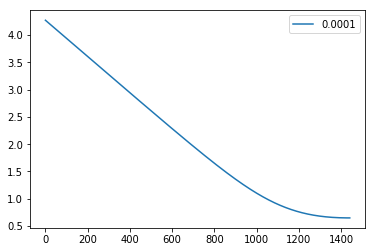

In [16]:
EPOCHS = 10000
LR = min_key

gd_params = np.copy(init_params)
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,gd_params,y_train)
    gd_params -= LR*gradients
    costs.append(log_reg_cost(X_train,gd_params,y_train))
    if len(costs)>2:
        if costs[-1] > costs[-2] > costs[-3]:
            print(f"EarlyStopping at {_} epoch")
            break

performance['GD'] = {'EPOCHS':np.argmin(costs)+1}
print(f"Achieved minimum of cost function with LR={LR} is {np.min(costs)} at {performance['GD']['EPOCHS']} epoch")
print(f"Final cost = {costs[-1]:.5f}")
plt.plot(range(len(costs)),costs,label=LR)

plt.legend()
_ = plt.show()

As we are training with full gradient descent simple comparision for growing cost function will do the trick for Early Stopping. It will not work with Stohastic approach due to noise.

Accuracy = 0.75, ROC_AUC=0.844


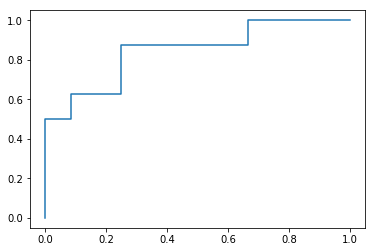

In [17]:
gd_pred_proba = log_reg_predict(X_test,gd_params)
from sklearn.metrics import roc_curve,roc_auc_score
tpr,fpr,thresh = roc_curve(y_test,gd_pred_proba)
plt.plot(tpr, fpr)
#accuracy
performance['GD']['ACCURACY'] = np.sum((gd_pred_proba > 0.5).astype(int) == y_test)/len(y_test)
performance['GD']['ROCAUC'] = roc_auc_score(y_test,gd_pred_proba)
print (f"Accuracy = {performance['GD']['ACCURACY']:.2f}, ROC_AUC={performance['GD']['ROCAUC']:.3f}")

# Nesterov with momentum

Achieved minimum of cost function with LR=0.0001 and GAMMA=0.5 is 0.6477945051962113 at 720 epoch
Achieved minimum of cost function with LR=1e-05 and GAMMA=0.5 is 2.947020087388687 at 2000 epoch
Achieved minimum of cost function with LR=1e-06 and GAMMA=0.5 is 4.142846114704054 at 2000 epoch
Achieved minimum of cost function with LR=1e-07 and GAMMA=0.5 is 4.262606081737907 at 2000 epoch
Achieved minimum of cost function with LR=0.0001 and GAMMA=0.9 is 0.6478864636532856 at 147 epoch
Achieved minimum of cost function with LR=1e-05 and GAMMA=0.9 is 0.6478011631248678 at 1442 epoch
Achieved minimum of cost function with LR=1e-06 and GAMMA=0.9 is 3.613444773815832 at 2000 epoch
Achieved minimum of cost function with LR=1e-07 and GAMMA=0.9 is 4.209644374015994 at 2000 epoch
Achieved minimum of cost function with LR=0.0001 and GAMMA=0.975 is 0.6486363217068258 at 63 epoch
Achieved minimum of cost function with LR=1e-05 and GAMMA=0.975 is 0.6479297336442091 at 376 epoch
Achieved minimum of cos

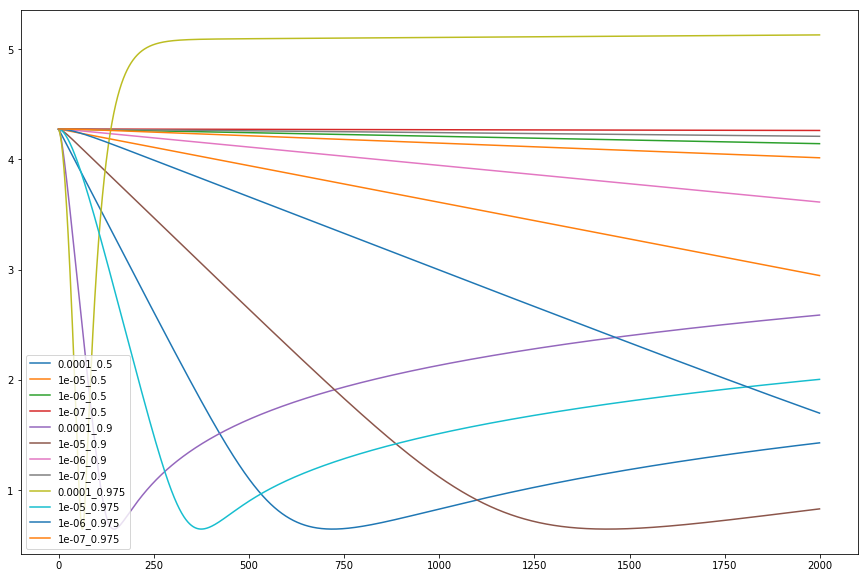

In [18]:
EPOCHS = 2000

minimum_costs = {}

plt.figure(figsize=(15,10))
for GAMMA in [.5,.9,.975]:
    for LR in [.0001,.00001,.000001,.0000001]:
        params = np.copy(init_params)

        momentum = np.zeros(params.shape[0])

        costs = []

        for _ in range(EPOCHS):
            gradients = log_reg_grad(X_train,params-GAMMA*momentum,y_train)
            momentum = GAMMA*momentum + LR*gradients
            params -= momentum
            #print(params)
            costs.append(log_reg_cost(X_train,params,y_train))

        print(f"Achieved minimum of cost function with LR={LR} and GAMMA={GAMMA} is {np.min(costs)} at {np.argmin(costs)+1} epoch")  
        plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")
        minimum_costs[(LR,GAMMA)] = np.min(costs)
plt.legend()
_ = plt.show()

In [19]:
min_key = sorted(minimum_costs,key=lambda x:minimum_costs[x], reverse=False)[0]
print(min_key,minimum_costs[min_key])

(0.0001, 0.5) 0.6477945051962113


EarlyStopping at 721 epoch
Achieved minimum of cost function with LR=0.0001 and GAMMA=0.5 is 0.6477945051962113 at 720 epoch
Final cost = 0.64781


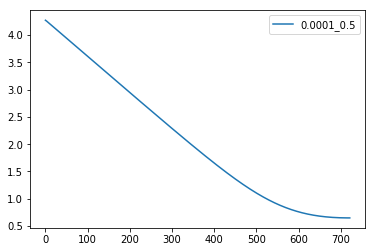

In [20]:
EPOCHS = 10000
LR = min_key[0]
GAMMA = min_key[1]

nes_params = np.copy(init_params)
momentum = np.zeros(params.shape[0])
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,nes_params-GAMMA*momentum,y_train)
    momentum = GAMMA*momentum + LR*gradients
    nes_params -= momentum
    #print(params)
    costs.append(log_reg_cost(X_train,nes_params,y_train))
    if len(costs)>2:
        if costs[-1] > costs[-2] > costs[-3]:
            print(f"EarlyStopping at {_} epoch")
            break

performance['NESTEROV'] = {'EPOCHS':np.argmin(costs)+1}
print(f"Achieved minimum of cost function with LR={LR} and GAMMA={GAMMA} is {np.min(costs)} at {performance['NESTEROV']['EPOCHS']} epoch")  
print(f"Final cost = {costs[-1]:.5f}")
plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")

plt.legend()
_ = plt.show()

With Nesterov optimization fucntion is able to converge faster with similar cost result. 721 epochs vs 1441 epochs

Accuracy = 0.75, ROC_AUC=0.844


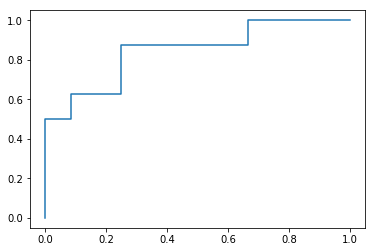

In [21]:
nes_pred_proba = log_reg_predict(X_test,nes_params)
from sklearn.metrics import roc_curve,roc_auc_score
tpr,fpr,thresh = roc_curve(y_test,nes_pred_proba)
plt.plot(tpr, fpr)
#accuracy
performance['NESTEROV']['ACCURACY'] = np.sum((nes_pred_proba > 0.5).astype(int) == y_test)/len(y_test)
performance['NESTEROV']['ROCAUC'] = roc_auc_score(y_test,nes_pred_proba)
print (f"Accuracy = {performance['NESTEROV']['ACCURACY']:.2f}, ROC_AUC={performance['NESTEROV']['ROCAUC']:.3f}")

# RMSProp

Achieved minimum of cost function with LR=0.1 and GAMMA=0.1 is 0.6869255167893898 at 6 epoch
Achieved minimum of cost function with LR=0.01 and GAMMA=0.1 is 0.659503533111273 at 57 epoch
Achieved minimum of cost function with LR=0.001 and GAMMA=0.1 is 0.6590263149905466 at 574 epoch
Achieved minimum of cost function with LR=0.0001 and GAMMA=0.1 is 2.8162531893817624 at 2000 epoch
Achieved minimum of cost function with LR=1e-05 and GAMMA=0.1 is 4.129792809452638 at 2000 epoch
Achieved minimum of cost function with LR=0.1 and GAMMA=0.5 is 0.6676541131189856 at 5 epoch
Achieved minimum of cost function with LR=0.01 and GAMMA=0.5 is 0.6593789350874042 at 57 epoch
Achieved minimum of cost function with LR=0.001 and GAMMA=0.5 is 0.6590173281396591 at 574 epoch
Achieved minimum of cost function with LR=0.0001 and GAMMA=0.5 is 2.8157870642062255 at 2000 epoch
Achieved minimum of cost function with LR=1e-05 and GAMMA=0.5 is 4.129745850801857 at 2000 epoch
Achieved minimum of cost function with 

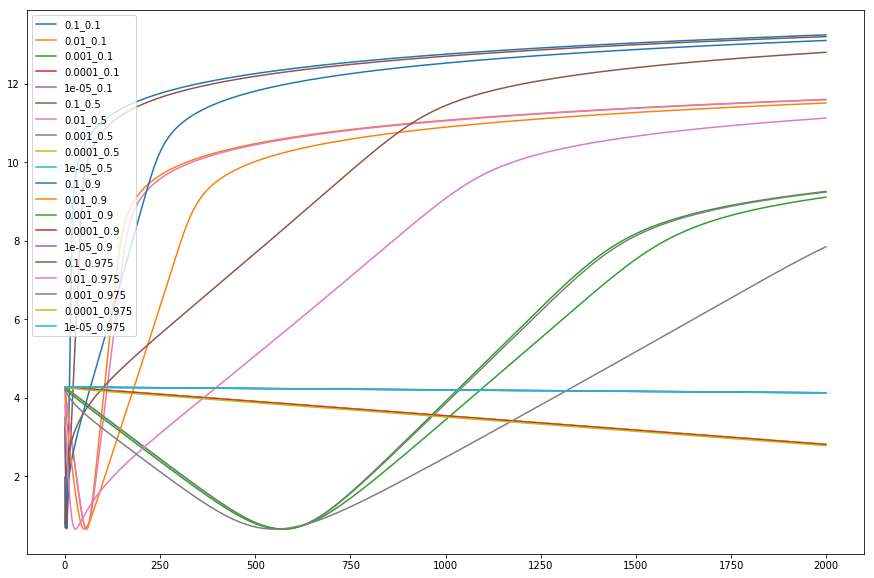

In [22]:
EPOCHS = 2000

minimum_costs = {}

plt.figure(figsize=(15,10))
for GAMMA in [.1,.5,.9,.975]:
    for LR in [.1,.01,.001,.0001,.00001]:
        params = np.copy(init_params)

        e = np.zeros(params.shape[0])

        costs = []

        for _ in range(EPOCHS):
            gradients = log_reg_grad(X_train,params-GAMMA*momentum,y_train)
            e = GAMMA*e + (1-GAMMA)*np.square(gradients)            
            params -= LR*gradients/np.sqrt(e+1e-10)
            #print(params)
            costs.append(log_reg_cost(X_train,params,y_train))

        print(f"Achieved minimum of cost function with LR={LR} and GAMMA={GAMMA} is {np.min(costs)} at {np.argmin(costs)+1} epoch")  
        minimum_costs[(LR,GAMMA)] = np.min(costs)
        plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")

plt.legend()
_ = plt.show()

In [23]:
min_key = sorted(minimum_costs,key=lambda x:minimum_costs[x], reverse=False)[0]
print(min_key,minimum_costs[min_key])

(0.01, 0.9) 0.6587548412663335


EarlyStopping at 53 epoch
Achieved minimum of cost function with LR=0.01 and GAMMA=0.9 is 0.6587548412663335 at 52 epoch
Final cost = 0.66454


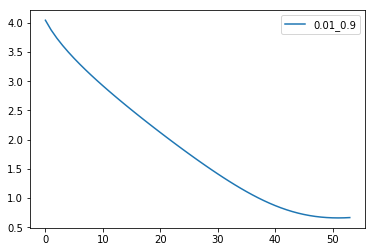

In [24]:
EPOCHS = 10000
LR = min_key[0]
GAMMA = min_key[1]

rms_params = np.copy(init_params)
e = np.zeros(rms_params.shape[0])
costs = []

for _ in range(EPOCHS):
    gradients = log_reg_grad(X_train,rms_params-GAMMA*momentum,y_train)
    e = GAMMA*e + (1-GAMMA)*np.square(gradients)            
    rms_params -= LR*gradients/np.sqrt(e+1e-10)
    #print(params)
    costs.append(log_reg_cost(X_train,rms_params,y_train))
    if len(costs)>2:
        if costs[-1] > costs[-2] > costs[-3]:
            print(f"EarlyStopping at {_} epoch")
            break

performance['RMSPROP'] = {'EPOCHS':np.argmin(costs)+1}
print(f"Achieved minimum of cost function with LR={LR} and GAMMA={GAMMA} is {np.min(costs)} at {performance['RMSPROP']['EPOCHS']} epoch")  
print(f"Final cost = {costs[-1]:.5f}")
plt.plot(range(len(costs)),costs,label=f"{LR}_{GAMMA}")

plt.legend()
_ = plt.show()

RMSProp is showing even faster convergance, but final value of cost is slightly higher comparing to other methods.

Accuracy = 0.75, ROC_AUC=0.885


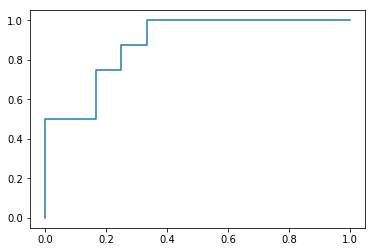

In [25]:
rms_pred_proba = log_reg_predict(X_test,rms_params)
from sklearn.metrics import roc_curve,roc_auc_score
tpr,fpr,thresh = roc_curve(y_test,rms_pred_proba)
plt.plot(tpr, fpr)
#accuracy
performance['RMSPROP']['ACCURACY'] = np.sum((rms_pred_proba > 0.5).astype(int) == y_test)/len(y_test)
performance['RMSPROP']['ROCAUC'] = roc_auc_score(y_test,rms_pred_proba)
print (f"Accuracy = {performance['RMSPROP']['ACCURACY']:.2f}, ROC_AUC={performance['RMSPROP']['ROCAUC']:.3f}")

# Conslusion

In [26]:
performance

{'GD': {'EPOCHS': 1440, 'ACCURACY': 0.75, 'ROCAUC': 0.84375},
 'NESTEROV': {'EPOCHS': 720, 'ACCURACY': 0.75, 'ROCAUC': 0.84375},
 'RMSPROP': {'EPOCHS': 52, 'ACCURACY': 0.75, 'ROCAUC': 0.8854166666666667}}

Improved optimization algorithms shows better performance, they learn faster and sometimes can even better optimize function